# Imports

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from datetime import datetime

random.seed(100)
np.random.seed(100)

# Funciones

In [2]:
def hist_chart(df, col, titulo, etiqueta):
    variable = df.groupby(col)[col].count()
    plt.title(titulo)
    plt.plot(variable.index, variable.values, label=etiqueta)
    plt.legend()
    plt.grid()
    plt.show()

def pareto_chart(df, col):
    fig, ax = plt.subplots(figsize=(15,5))
    plt.title(f"Distribución por {col}")
    plt.xticks(rotation=90)
    ax.bar(df[col].value_counts().index, df[col].value_counts().values)
    ax2 = ax.twinx()
    ax2.plot(df[col].value_counts().index, df[col].value_counts().cumsum() / df.shape[0])
    ax2.axhline(0.8, color = 'r')
    plt.show()

def get_periodo_dia(x):
    if 5 <= x < 12:
        return "mañana"
    elif 12 <= x < 19:
        return "tarde"
    else:
        return "noche"
    
def categorical_plot(df, hue, y):
    data = {}
    
    for flag in df[y].unique():
        data[flag] = []
        
        values = np.sort( df[hue].unique() )
        for value in values:
            rows = df[(df[hue] == value) & (df[y] == flag)].shape[0]
            total = df[(df[hue] == value)].shape[0]
            data[flag].append( rows/total )
            
    " To replace numbers by text"
    mask = {}
    for i, value in enumerate(np.sort(df[hue].unique())):
        mask[i] = str(value)
        
    plt.subplots(figsize=(18,6))
    for flag in data.keys():
        if flag == 1:
            plt.plot( np.asarray(data[flag]), label=f"Clase {flag}", marker="o")
    
    plt.legend()
    plt.title(f"Categorical: Distribución por {hue}", size=18)
    plt.xlabel(f"{hue}", size=15)
    plt.ylabel(f"{y}", size=15)
    plt.xticks(list(mask.keys()), list(mask.values()), rotation=90, size=18)
    plt.show()
    
def plot_roc_curve(y, scores):
    auc = round(100 * roc_auc_score(y, scores))
    fpr_rt, tpr_rt, _ = roc_curve(y, scores)
    plt.plot(fpr_rt, tpr_rt, label='RT + LR')
    plt.title(f"AUC {auc}%")
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Cargar el Dataset

In [3]:
data = pd.read_csv('dataset_SCL.csv')
display(data.head(5))

/var/folders/zw/b42_qgc508n15bfdt_vh4d040000gn/T/ipykernel_7911/4151164970.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset_SCL.csv')


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [4]:
# Formatear datos de fecha

data["Fecha-I"] = data["Fecha-I"].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))
data["Fecha-O"] = data["Fecha-O"].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'))

# P1. ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

In [6]:
print(f'Cantidad de vuelos: {data.shape[0]}')

Cantidad de vuelos: 68206


In [7]:
print(f'Total de valores NA: {data.isna().sum().sum()}')

Total de valores NA: 1


In [8]:
# Ya que solo hay 1 valor nulo, se eliminará
data = data.dropna()

In [9]:
print(f'Años de operacion: {data["AÑO"].unique()}')

print(f'Ciudades de origen: {data["Ori-I"].nunique()}')

print(f'Ciudades de destino: {data["Des-I"].nunique()}')

print(f'Cantidad de aerolíneas: {data["Emp-I"].nunique()}')

Años de operacion: [2017 2018]
Ciudades de origen: 1
Ciudades de destino: 64
Cantidad de aerolíneas: 30


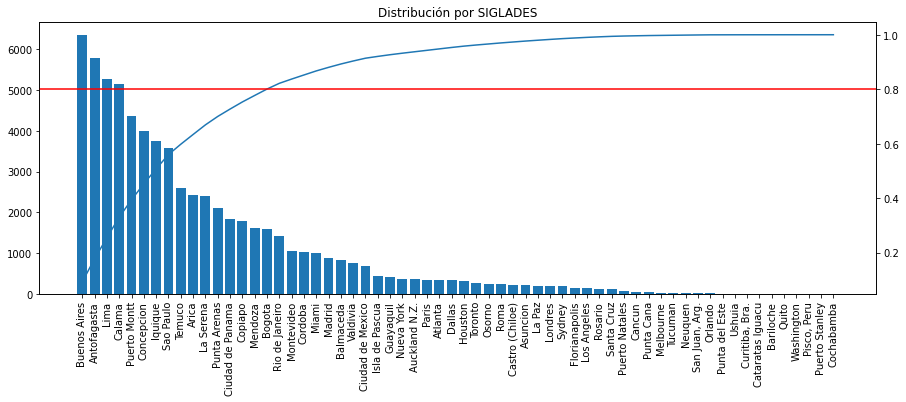

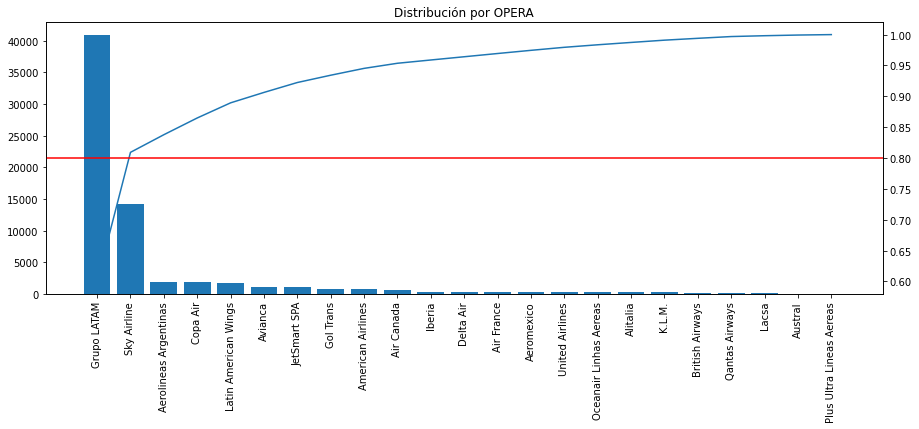

In [10]:
pareto_chart(data, 'SIGLADES')
pareto_chart(data, 'OPERA')

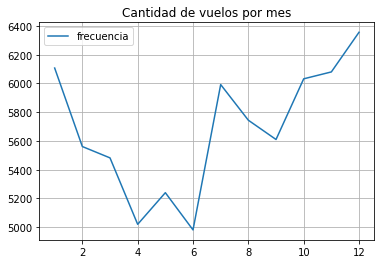

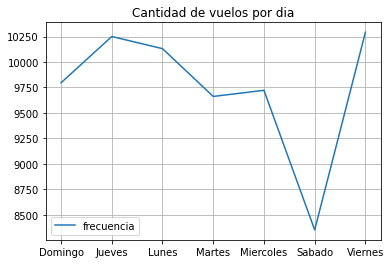

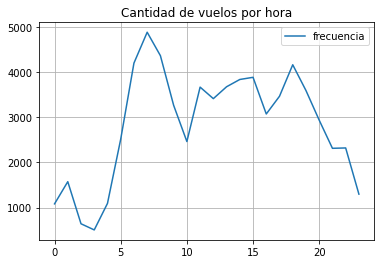

In [11]:
hist_chart(data, 'MES', 'Cantidad de vuelos por mes', 'frecuencia')
hist_chart(data, 'DIANOM', 'Cantidad de vuelos por dia', 'frecuencia')
hist_chart(data, 'Hour-I', 'Cantidad de vuelos por hora', 'frecuencia')

Del total de los vuelos realizados, todos tienen su origen en Santiago, en cambio existen 64 ciudades de destinos, donde 16 de ellos concentran el 80% de los viajes. Tambien se tienen 23 aerolineas registradas, pero 2 de ellas, grupo latam y sky airline, realizaron mas del 80% de los viajes. 

Por otra parte se logra identificar que a partir de febrero hay una baja en los viajes y luego en el mes de julio comienza una tendencia al alza. El dia con menos viajes corresponde al sabado, mientras que los dias con mas viajes son el viernes y jueves. Por ultimo, entre las 5am y 20pm se realizan la mayor cantidad de vuelos.

# P2. Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv

In [12]:
data["temporada_alta"] =  (("2016-12-15" <= data["Fecha-I"]) & (data["Fecha-I"] <= "2017-03-03")) | \
                        (("2017-07-15" <= data["Fecha-I"]) & (data["Fecha-I"] <= "2017-07-31")) | \
                        (("2017-09-11" <= data["Fecha-I"]) & (data["Fecha-I"] <= "2017-09-30")) | \
                        (("2017-12-15" <= data["Fecha-I"]) & (data["Fecha-I"] <= "2018-03-03"))

data["temporada_alta"] = data["temporada_alta"].astype(int)

data["diff_min"] = (data["Fecha-O"] - data["Fecha-I"]).dt.seconds / 60
data["atraso_15"] = (data["diff_min"] > 15).astype(int)
data["periodo_dia"] = data["Hour-I"].apply(lambda x: get_periodo_dia(x))

data.to_csv("syntehtic_features.csv", index=False, sep=";")

In [13]:
print("Cantidad de vuelos con atrasos menores a 15 minutos: ", (data['atraso_15'] == 0).sum())
print("Cantidad de vuelos con atrasos mayores a 15 minutos: ", (data['atraso_15'] == 1).sum())

print("Cantidad de vuelos en temporada alta: ", (data['temporada_alta'] == 1).sum())

Cantidad de vuelos con atrasos menores a 15 minutos:  37681
Cantidad de vuelos con atrasos mayores a 15 minutos:  30524
Cantidad de vuelos en temporada alta:  22210


# P3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? ¿Qué variables esperarías que más influyeran en predecir atrasos?

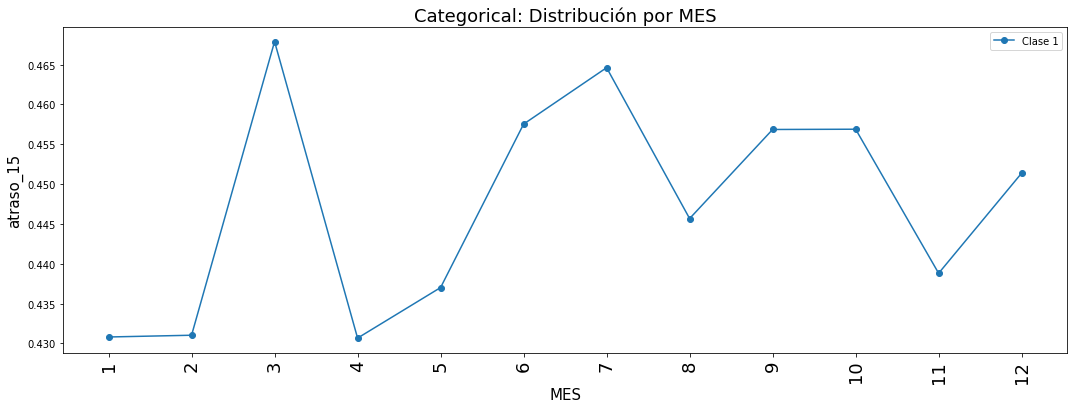

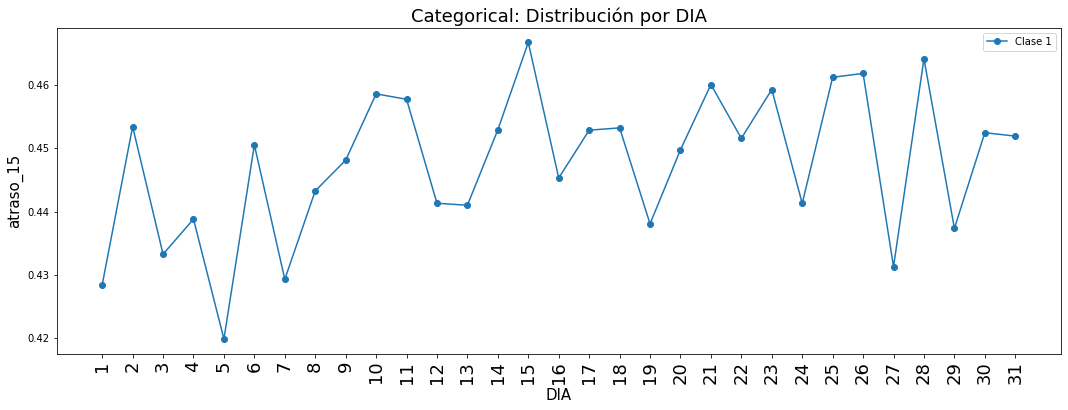

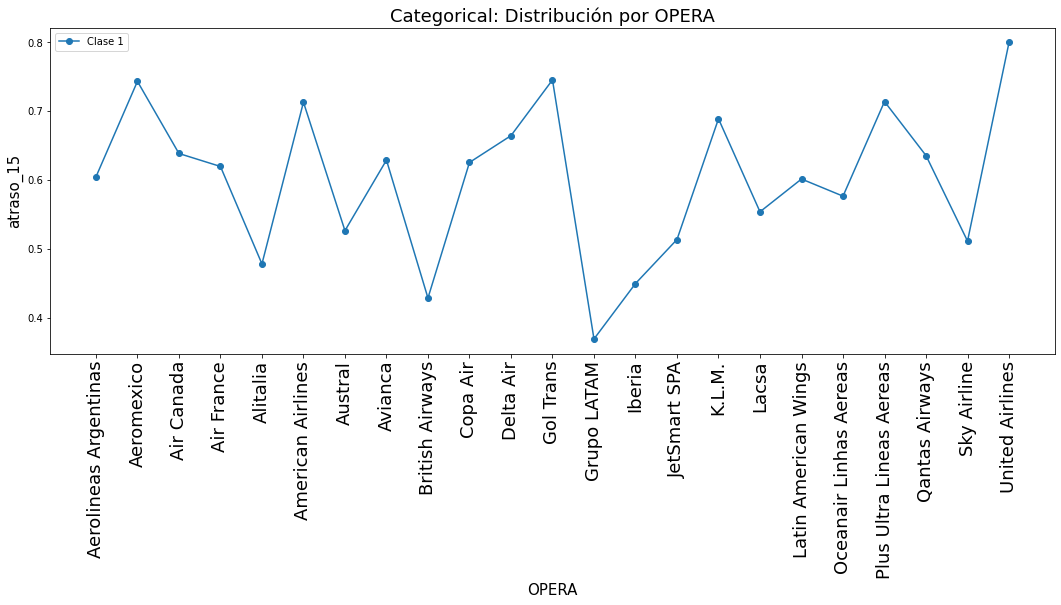

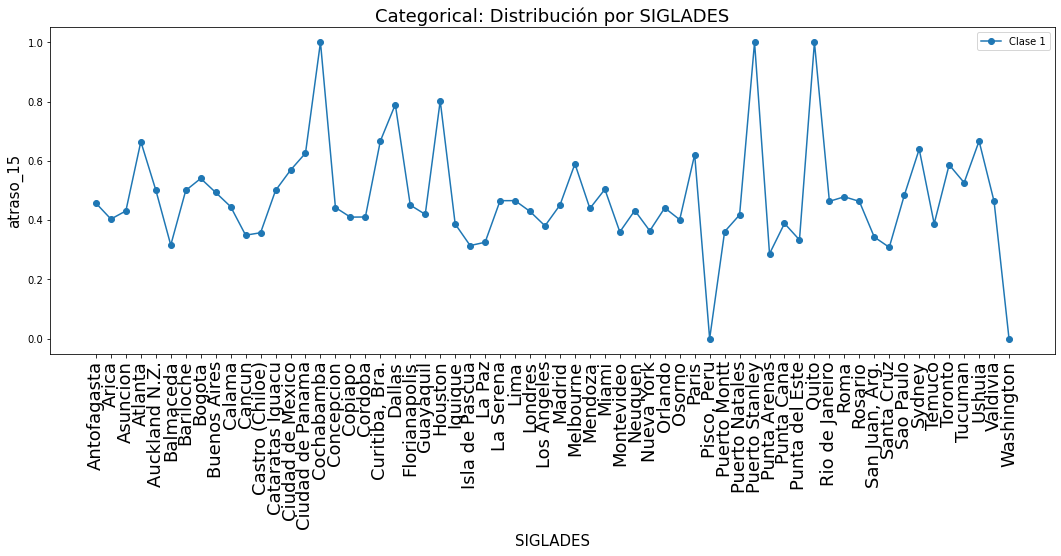

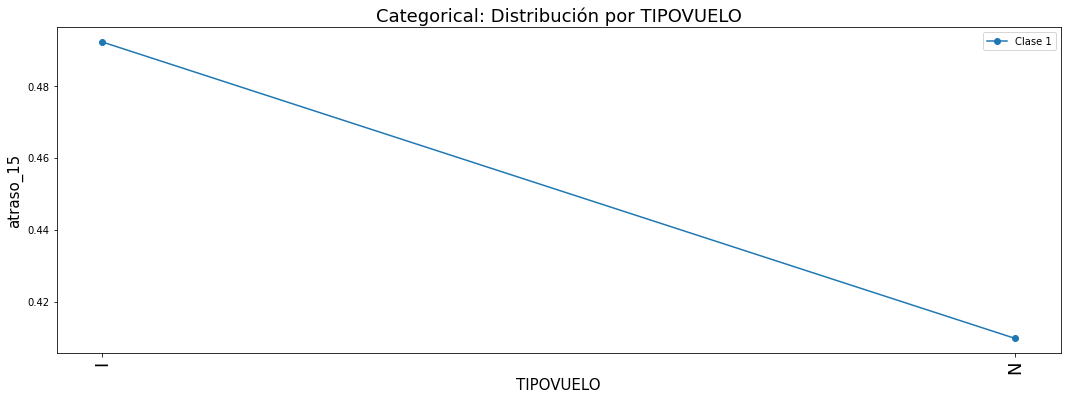

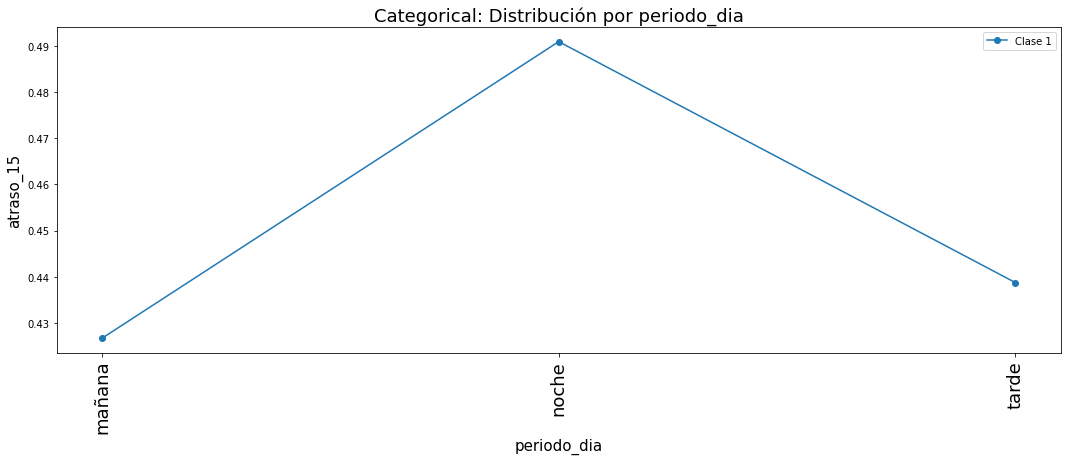

In [14]:
categorical_plot(data, hue="MES", y="atraso_15")
categorical_plot(data, hue="DIA", y="atraso_15")
categorical_plot(data, hue="OPERA", y="atraso_15")
categorical_plot(data, hue="SIGLADES", y="atraso_15")
categorical_plot(data, hue="TIPOVUELO", y="atraso_15") 
categorical_plot(data, hue="periodo_dia", y="atraso_15")

Tasa de atraso por variable
 
* Del gráfico por mes se puede ver que hay hasta un 3% de diferencia en la tasa de atraso. Enero, febrero y abril son los que tienen las menores tasas de atraso.
* El gráfico por día tiene diferencias de hasta un 5% en la tasa de atraso. El día 5 es el que tiene menor tasa de atraso y el 15 el que tiene mayor.
* El gráfico de las operadoras muestra que hay diferencias significativas entre ellas, por ejemplo, United Airlines tiene una tasa de atraso del 80% contra Grupo Latam que tiene una tasa de atrasos menor al 50%. Hay que destacar, que LATAM es el que controla la mayor cantidad de tráfico aéreo.
* El gráfico por destino muestra que hay diferencias entre los destinos, por ejemplo Dallas y Houston tasas de atraso del 80% vs Punta Arenas y Balmaceda que tienen tasas de atraso del 30%. Todos los destinos con valores cercanos a 1% o 0% son aquellos que tienen muy pocos datos.
* De acuerdo al tipo de vuelo, los nacionales tienen menor tasa de atraso que los internacionales.
* Para el periodo del día se tiene que la noche tiene 6% más tasa de atrasos que la mañana y la tarde.
 
<br>
Otros elementos que posiblemente influyan, es el tamaño del avión, la cantidad de pasajeros, la tasa de ocupación del aeropuerto, si el avión del vuelo viene desde un vuelo anterior, si es escala, etc.

# P4. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo.

In [15]:
COLS = ["atraso_15", "MES" , "DIA", "OPERA", "SIGLADES", "TIPOVUELO", "periodo_dia"]
df = data[COLS]

In [16]:
X = df.drop(labels="atraso_15", axis=1)
y = df["atraso_15"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [17]:
CATEGORICAL_COLS = ["OPERA", "SIGLADES", "TIPOVUELO", "periodo_dia"]

In [18]:
cat_encoder = OneHotEncoder(handle_unknown='ignore')


X_train_categorical = X_train[CATEGORICAL_COLS]
X_test_categorical = X_test[CATEGORICAL_COLS]

cat_encoder.fit(X_train_categorical)

X_train_categorical = cat_encoder.transform(X_train_categorical).toarray()
X_test_categorical = cat_encoder.transform(X_test_categorical).toarray()



x_train = pd.concat([X_train.drop(labels=CATEGORICAL_COLS, axis=1).reset_index(drop=True), 
                                   pd.DataFrame(X_train_categorical,columns=cat_encoder.get_feature_names_out())], axis=1)

x_test = pd.concat([X_test.drop(labels=CATEGORICAL_COLS, axis=1).reset_index(drop=True), 
                                   pd.DataFrame(X_test_categorical,columns=cat_encoder.get_feature_names_out())], axis=1)

# P5. Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la performance?

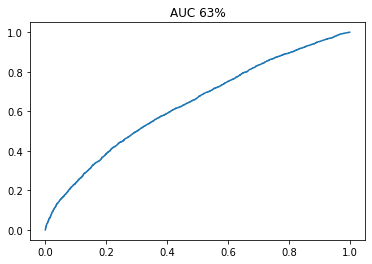

Precision: 59.85%
Recall: 41.59%
Confusion matrix, without normalization
[[5913 1686]
 [3529 2513]]


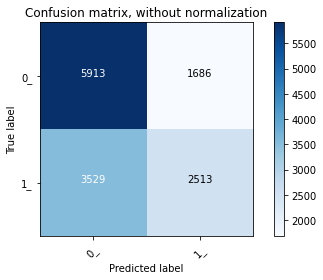

In [19]:
model = xgb.XGBClassifier(
             learning_rate =0.1,
             n_estimators=100,
             max_depth=10,
             min_child_weight=1,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.2,
             objective= 'binary:logistic',
             nthread=4,
             scale_pos_weight=1,
             seed=27)

model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)
y_test_scores = model.predict_proba(x_test)
y_test_scores = [x[1] for x in y_test_scores]
cnf_matrix = confusion_matrix(y_test, y_test_pred)


pre = round(  100 * precision_score( y_test, y_test_pred) , 2)
rec = round(  100 * recall_score( y_test, y_test_pred) , 2)
plot_roc_curve(y_test, y_test_scores)

print(f"Precision: {pre}%")
print(f"Recall: {rec}%")
plot_confusion_matrix(cnf_matrix, classes=["0_", "1_"],
                      title='Confusion matrix, without normalization')
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

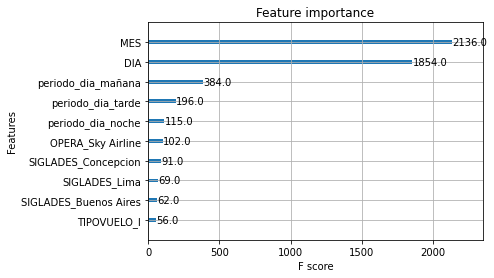

In [20]:
xgb.plot_importance(model,  max_num_features=10)

Utilice xgboost ya que es conocido por tener buen performance y no es necesario escalar las variables.
 
Respecto a las métricas calculé diferentes: precisión, recall, auc. Las razones son las siguientes: La curva ROC indica la evolución de la tasa de verdaderos positivos y tasa de falsos positivos para diferentes umbrales de decisión. Esto es útil cuando se quiere establecer un modo de operación que privilegie el recall o precisión.
 
La precisión indica que tan confiable es la clasificación del modelo, mientras que el recall indica que tan sensible es el modelo.
 
Para el modelo realizado con XGBOOST se utilizó one hot encoding para cada variable categórica (una columna por cada valor).
 
Este modelo alcanzó un AUC de 63%, una precisión de 60.27% y un recall de 42%. Estas medidas indican que el 60% de las deteciones de atrasos en los vuelos del modelo son correctos, pero se estan contabilizando el 42% de todos los atrasos.
 
Para obtener la importancia de las variables usé el F-score de XGBOOST, de donde se obtiene que las variables mas importantes corresponden al med y el día del vuelo, por sobre el resto de variables.
 
Por último, para mejorar el performance de cualquier modelo entrenado es necesario incluir más atributos como el clima, tipo de avión, cantidad de pasajeros, si el avión viene de otro vuelo, la saturación del aeropuerto y probablemente un montón de otros atributos que puedan ser mucho mejores indicadores que el dia de la semana o la estación del año o el mes.